# Learning the Bridge function


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interpn

from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tqdm.keras import TqdmCallback

In [2]:
def make_model(input_dim, lam=1e-5):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(1, activation='linear', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def train_model(model, X_train, y_train, y_var, batch_size=128, epochs=100, \
             save_file=False, training_curve=True, val_split=0.1):
    print("Learning MLP model with {} training points".format(len(y_train)))

    try:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, sample_weight=y_var, \
                            validation_split=val_split, verbose=0, callbacks=[TqdmCallback(verbose=1)])
    except KeyboardInterrupt:
        pass
    
    if save_file:
        model.save(save_file)  # creates a HDF5 file 'my_model.h5'
    
    if training_curve:
        # "Loss"
        plt.figure(figsize=(10,8))
        matplotlib.rcParams.update({'font.size': 15})
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
    
    return model

In [3]:
df_train = pd.read_csv("datasets/random-train.csv")
X_train_gam = df_train[["avg_icf",]].values
X_train_la = df_train[["avg_tcf","avg_dcf",]].values
X_train_fd = df_train[["avg_tcf","avg_dcf","fd_gr",]].values
X_train_nla = df_train[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_train = df_train[["avg_br"]].values
y_ivar = (df_train[["err_br"]].values**-2.).ravel()
# y_ivar = np.ones(len(df_train))

In [4]:
df_test = pd.read_csv("datasets/random-test.csv")
X_test_gam = df_test[["avg_icf",]].values
X_test_la = df_test[["avg_tcf","avg_dcf",]].values
X_test_fd = df_test[["avg_tcf","avg_dcf","fd_gr",]].values
X_test_nla = df_test[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_test = df_test[["avg_br"]].values

In [5]:
# gam = make_model(1)
# local = make_model(2)
# fluct = make_model(3)
# non_local = make_model(4)

In [6]:
gam = load_model("models/gam.h5")
local = load_model("models/local.h5")
fluct = load_model("models/fluct.h5")
non_local = load_model("models/non-local.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# gam = train_model(gam, X_train_gam, y_train, y_ivar, 
#                     epochs=100, save_file="models/gam-200.h5")

In [8]:
# local = train_model(local, X_train_la, y_train, y_ivar, 
#                     epochs=100, save_file="models/local-200.h5")

In [9]:
# fluct = train_model(fluct, X_train_fd, y_train, y_ivar, 
#                      epochs=100, save_file="models/fluct-200.h5")

In [10]:
# non_local = train_model(non_local, X_train_nla, y_train, y_ivar, 
#                      epochs=100, save_file="models/non-local-500.h5")

In [11]:
y_gam = gam.predict(X_test_gam)
y_local = local.predict(X_test_la)
y_fluct = fluct.predict(X_test_fd)
y_non_local = non_local.predict(X_test_nla)

r2_hnc = r2_score(np.zeros_like(y_test), y_test)
r2_gam = r2_score(y_gam, y_test)
r2_local = r2_score(y_local, y_test)
r2_fluct = r2_score(y_fluct, y_test)
r2_non_local = r2_score(y_non_local, y_test)

rmse_hnc = np.sqrt(MSE(np.zeros_like(y_test), y_test))
rmse_gam = np.sqrt(MSE(y_gam, y_test))
rmse_local = np.sqrt(MSE(y_local, y_test))
rmse_fluct = np.sqrt(MSE(y_fluct, y_test))
rmse_non_local = np.sqrt(MSE(y_non_local, y_test))

mae_hnc = MAE(np.zeros_like(y_test), y_test)
mae_gam = MAE(y_gam, y_test)
mae_local = MAE(y_local, y_test)
mae_fluct = MAE(y_fluct, y_test)
mae_non_local = MAE(y_non_local, y_test)


In [12]:
print("         :   R2  , RMSE ,  MAE  ")
print("HNC      :  {:.3f}, {:.3f}, {:.3f}".format(r2_hnc, rmse_hnc, mae_hnc))
print("Gam      : {:.3f}, {:.3f}, {:.3f}".format(r2_gam, rmse_gam, mae_gam))
print("Local    :  {:.3f}, {:.3f}, {:.3f}".format(r2_local, rmse_local, mae_local))
print("Fluct    :  {:.3f}, {:.3f}, {:.3f}".format(r2_fluct, rmse_fluct, mae_fluct))
print("Non-Local:  {:.3f}, {:.3f}, {:.3f}".format(r2_non_local, rmse_non_local, mae_non_local))

         :   R2  , RMSE ,  MAE  
HNC      :  0.000, 0.104, 0.028
Gam      : -1.266, 0.092, 0.021
Local    :  0.326, 0.073, 0.017
Fluct    :  0.583, 0.059, 0.013
Non-Local:  0.878, 0.037, 0.009


In [13]:
def density_scatter(x , y, colours, ax = None, label=None, sort = True, log=True, bins = 50,  **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
        
    data , x_e, y_e = np.histogram2d(x, y, bins = bins)
    
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    
    if log:
        z = np.log(z)    
    
    ax.scatter( x, y, c=z, cmap=colours, label=label, **kwargs )
    return ax

/home/reag2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


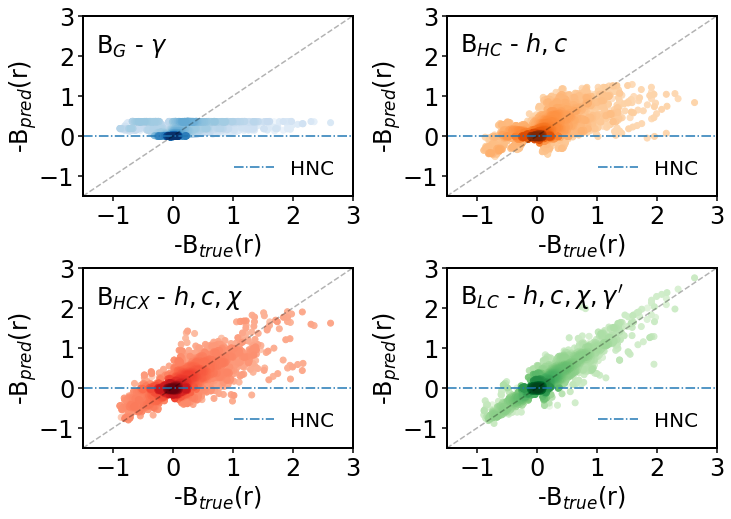

In [16]:
# plt.rc('font', family='serif')
plt.rc('font', size=24)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1.5

fig, ax = plt.subplots(2,2, figsize=(10, 7.5))
plt.subplots_adjust(top=0.95, bottom=0.15, 
                    wspace=0.35, hspace=0.40,
                    left=0.10, right=0.98,)

density_scatter(-y_test.ravel(), -y_gam.ravel(), plt.get_cmap('Blues'), ax=ax[0,0])

density_scatter(-y_test.ravel(), -y_local.ravel(), plt.get_cmap('Oranges'), ax=ax[0,1])

density_scatter(-y_test.ravel(), -y_fluct.ravel(), plt.get_cmap('Reds'), ax=ax[1,0])

density_scatter(-y_test.ravel(), -y_non_local.ravel(), plt.get_cmap('Greens'), ax=ax[1,1])

# ax[0,0].plot(-y_test, -y_gam, linestyle="None",
#         marker="+", label='$B_{ga}$', alpha=0.3,mew=3, color="tab:blue")

# ax[0,1].plot(-y_test, -y_local, linestyle="None",
#         marker="+", label='$B_{la}$', alpha=0.3,mew=3, color="tab:orange")

# ax[1,0].plot(-y_test, -y_fluct, linestyle="None",
#         marker="x", label='$B_{fa}$', alpha=0.3,mew=3, color="tab:green")

# ax[1,1].plot(-y_test, -y_non_local, linestyle="None",
#         marker="x", label='$B_{nla}$', alpha=0.3,mew=3, color="tab:red")   

ax[0,0].plot([-1.5, 3], [0, 0], linestyle="-.", label='HNC', color="tab:blue")
ax[0,0].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[0,0].set_xlabel('-B$_{true}$(r)')
ax[0,0].set_ylabel('-B$_{pred}$(r)', labelpad=0)
ax[0,0].set_xlim((-1.5,3))
ax[0,0].set_ylim((-1.5,3))
ax[0,0].set_xticks((-1,0,1,2,3))
ax[0,0].set_yticks((-1,0,1,2,3))

ax[0,1].plot([-1.5, 3], [0, 0], linestyle="-.", label='HNC', color="tab:blue")
ax[0,1].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[0,1].set_xlabel('-B$_{true}$(r)')
ax[0,1].set_ylabel('-B$_{pred}$(r)', labelpad=0)
ax[0,1].set_xlim((-1.5,3))
ax[0,1].set_ylim((-1.5,3))
ax[0,1].set_xticks((-1,0,1,2,3))
ax[0,1].set_yticks((-1,0,1,2,3))

ax[1,0].plot([-1.5, 3], [0, 0], linestyle="-.", label='HNC', color="tab:blue")
ax[1,0].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[1,0].set_xlabel('-B$_{true}$(r)')
ax[1,0].set_ylabel('-B$_{pred}$(r)', labelpad=0)
ax[1,0].set_xlim((-1.5,3))
ax[1,0].set_ylim((-1.5,3))
ax[1,0].set_xticks((-1,0,1,2,3))
ax[1,0].set_yticks((-1,0,1,2,3))

ax[1,1].plot([-1.5, 3], [0, 0], linestyle="-.", label='HNC', color="tab:blue")
ax[1,1].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[1,1].set_xlabel('-B$_{true}$(r)')
ax[1,1].set_ylabel('-B$_{pred}$(r)', labelpad=0)
ax[1,1].set_xlim((-1.5,3))
ax[1,1].set_ylim((-1.5,3))
ax[1,1].set_xticks((-1,0,1,2,3))
ax[1,1].set_yticks((-1,0,1,2,3))

ax[0,0].legend(markerscale=1, fontsize=20, frameon=False, loc=4)
ax[0,1].legend(markerscale=1, fontsize=20, frameon=False, loc=4)
ax[1,0].legend(markerscale=1, fontsize=20, frameon=False, loc=4)
ax[1,1].legend(markerscale=1, fontsize=20, frameon=False, loc=4)

ax[0,0].annotate("B$_{G}$ - $\gamma$", (0.05,0.8), xycoords='axes fraction', fontsize=24)
ax[0,1].annotate("B$_{HC}$ - $h, c$", (0.05,0.8), xycoords='axes fraction', fontsize=24)
ax[1,0].annotate("B$_{HCX}$ - $h, c, \chi$", (0.05,0.8), xycoords='axes fraction', fontsize=24)
ax[1,1].annotate("B$_{LC}$ - $h, c, \chi, \gamma'$", (0.05,0.8), xycoords='axes fraction', fontsize=24)

# plt.tight_layout()

# plt.savefig("plots/compare_{}.png".format(datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")))
plt.savefig("plots/compare.png", dpi=600)
plt.show()
